In [1]:
import numpy as np
import cvxpy as cp
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import sympy as sym
from matplotlib.ticker import MaxNLocator
import qutip as q
tol = 1e-9
plt.rcParams['font.size'] = 100
plt.rcParams['font.family'] = 'serif'
plt.rcParams["figure.figsize"] = (48,27)
plt.rcParams['legend.fontsize'] = 100
plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['mathtext.rm'] =  'Times New Roman'
# plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
# plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
# plt.rcParams['mathtext.cal'] = 'cursive'
plt.rcParams['axes.linewidth'] = 5
plt.rcParams['xtick.major.pad']='15'
plt.rcParams['ytick.major.pad']='15'
tol = 1e-30

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
class channel:
    
    def __init__(self, n, A_list):
        self.n = n
        self.A_list = A_list
        return
    
    def operate(self, rho):
        rho_out = rho*0
        for A in self.A_list:
            rho_out = rho_out + A*rho*A.dag()
        return rho_out
    
def Rotation(G, theta, l1, l2, d):
    U = np.identity(d,dtype=np.complex128)
    Rot = (-1j*theta*G/2).expm()
    U[l1,l1], U[l1,l2], U[l2,l1], U[l2,l2] = Rot[0,0], Rot[0,1], Rot[1,0], Rot[1,1]
    return q.Qobj(U)
    

In [4]:
gellmann_mat = [np.array([[0,1,0],[1,0,0],[0,0,0]]),
                np.array([[0,-1j,0],[1j,0,0],[0,0,0]]),
                np.array([[1,0,0],[0,-1,0],[0,0,0]]),
                np.array([[0,0,1],[0,0,0],[1,0,0]]),
                np.array([[0,0,-1j],[0,0,0],[1j,0,0]]),
                np.array([[0,0,0],[0,0,1],[0,1,0]]),
                np.array([[0,0,0],[0,0,-1j],[0,1j,0]]),
                np.array([[1,0,0],[0,1,0],[0,0,-2]])/np.sqrt(3)]

def gellmann_rot(th):
    rot = np.identity(3)
    for i in range(8):
        rot = scipy.linalg.expm(-1j*th[i]*gellmann_mat[i]/2)@rot
    return q.Qobj(rot)

In [5]:
proj1 = q.Qobj([[0,0],[0,1]])
proj0 = q.Qobj([[1,0],[0,0]])
I = q.identity(2)
X = q.sigmax()
Y = q.sigmay()
Z = q.sigmaz()
pproj0 = q.Qobj([[1,0,0],[0,0,0],[0,0,0]])
pproj1 = q.Qobj([[0,0,0],[0,1,0],[0,0,0]])
pproj2 = q.Qobj([[0,0,0],[0,0,0],[0,0,1]])
II = q.identity(3)
ZZ = q.Qobj(np.diagflat([1,np.exp(2j*np.pi/3),np.exp(4j*np.pi/3)]))
XX = q.Qobj([[0,1,0],[0,0,1],[1,0,0]])

class mult_VQ_HT:
    
    def __init__(self, map0, map1, map2, layers):
        self.map0 = map0
        self.map1 = map1
        self.map2 = map2
        self.V_layers = layers
        self.init = q.ghz_state(4)*q.ghz_state(4).dag()
        self.V_theta = np.zeros(20*(layers+1))
        self.V = q.tensor(II,q.tensor(q.tensor(I,I),q.tensor(I,I)))
    
    def succ_prob(self):
        rho = self.init
        Pi_0 = q.tensor(pproj0,q.tensor(q.tensor(I,I),q.tensor(I,I)))
        Pi_1 = q.tensor(pproj1,q.tensor(q.tensor(I,I),q.tensor(I,I)))
        Pi_2 = q.tensor(pproj2,q.tensor(q.tensor(I,I),q.tensor(I,I)))
        rho0 = self.V*q.tensor(pproj0,self.map0.operate(rho))*self.V.dag()
        rho1 = self.V*q.tensor(pproj0,self.map1.operate(rho))*self.V.dag()
        rho2 = self.V*q.tensor(pproj0,self.map2.operate(rho))*self.V.dag()
        #print(np.trace((Pi_0*rho0).full()), np.trace((Pi_1*rho1).full()), np.trace((Pi_2*rho2).full()))
        return np.trace((Pi_0*rho0).full() + (Pi_1*rho1).full() + (Pi_2*rho2).full())/3
        
    def evaluate_V(self):
        th = self.V_theta
        V = q.tensor(II,q.tensor(q.tensor(I,I),q.tensor(I,I)))
        for i in range(self.V_layers+1):
            rotation = gellmann_rot(th[i*20:i*20+8])
            for j in range(4):
                rotation = q.tensor(rotation,q.rz(th[i*20 + 8 + 3*j + 0])*q.rx(th[i*20 + 8 + 3*j + 1])*q.rz(th[i*20 + 8 + 3*j + 2]))
            V = rotation*V
            if i < self.V_layers:
                V = (q.tensor(II,q.tensor(q.tensor(proj0,I),q.tensor(I,I)) + 
                     q.tensor(q.tensor(proj1,Z),q.tensor(I,I))))*V
#                 V = (q.tensor(I,q.tensor(q.tensor(I,I),q.tensor(proj0,I)) + 
#                      q.tensor(q.tensor(I,I),q.tensor(proj1,Z))))*V
                V = (q.tensor(II,q.tensor(q.tensor(proj0,I),q.tensor(I,I))) + 
                     q.tensor(ZZ,q.tensor(q.tensor(proj1,I),q.tensor(I,I))))*V
                V = (q.tensor(II,q.tensor(q.tensor(I,I),q.tensor(proj0,I)) + 
                     q.tensor(q.tensor(Z,I),q.tensor(proj1,I))))*V
                V = (q.tensor(II,q.tensor(q.tensor(I,proj0),q.tensor(I,I)) + 
                     q.tensor(q.tensor(I,proj1),q.tensor(I,Z))))*V
                V = (q.tensor(pproj0+pproj2,q.tensor(q.tensor(I,I),q.tensor(I,I))) + 
                     q.tensor(pproj1,q.tensor(q.tensor(I,I),q.tensor(I,Z))))*V
                V = (q.tensor(pproj0+pproj1,q.tensor(q.tensor(I,I),q.tensor(I,I))) + 
                     q.tensor(pproj2,q.tensor(q.tensor(I,I),q.tensor(I,Z))))*V
                V = (q.tensor(II,q.tensor(q.tensor(I,I),q.tensor(proj0,I))) + 
                     q.tensor(ZZ,q.tensor(q.tensor(I,I),q.tensor(proj1,I))))*V
                V = (q.tensor(pproj0+pproj2,q.tensor(q.tensor(I,I),q.tensor(I,I))) + 
                     q.tensor(pproj1,q.tensor(q.tensor(Z,I),q.tensor(I,I))))*V
                V = (q.tensor(pproj0+pproj1,q.tensor(q.tensor(I,I),q.tensor(I,I))) + 
                     q.tensor(pproj2,q.tensor(q.tensor(Z,I),q.tensor(I,I))))*V
        self.V = V
        
    def _cost(self,x):
        self.V_theta = x
        self.evaluate_V()
        return -self.succ_prob()
    
    def optimize(self):
        x0 = np.random.uniform(-np.pi,np.pi,size=len(self.V_theta))
        opti = scipy.optimize.minimize(self._cost,x0=x0)
        self.V_theta = opti.x
        self.evaluate_V()
        return -opti.fun
        
    def optimize_true(self,verbose_flag=False):
        Pi0 = cp.Variable((16,16),complex=True)
        Pi1 = cp.Variable((16,16),complex=True)
        Pi2 = cp.Variable((16,16),complex=True)
        rho0 = (self.map0.operate(self.init)).full()
        rho1 = (self.map1.operate(self.init)).full()
        rho2 = (self.map2.operate(self.init)).full()
        WarmPi0 = ((self.V.dag()*q.tensor(pproj0,q.tensor(q.tensor(I,I),q.tensor(I,I)))*self.V).ptrace([1,2,3,4])).full()
        WarmPi1 = ((self.V.dag()*q.tensor(pproj1,q.tensor(q.tensor(I,I),q.tensor(I,I)))*self.V).ptrace([1,2,3,4])).full()
        WarmPi2 = ((self.V.dag()*q.tensor(pproj2,q.tensor(q.tensor(I,I),q.tensor(I,I)))*self.V).ptrace([1,2,3,4])).full()
        constraints = [Pi0>>0, Pi1>>0, Pi2>>0, Pi0 + Pi1 + Pi2 == np.identity(16)]
        init_prob = cp.Problem(cp.Minimize((cp.norm(WarmPi0-Pi0) + cp.norm(WarmPi1-Pi1) + cp.norm(WarmPi2-Pi2))),constraints)
        init_prob.variables()[0].save_value(WarmPi0)
        init_prob.variables()[1].save_value(WarmPi1)
        init_prob.variables()[2].save_value(WarmPi2)
        init_prob._value = init_prob.objective.value
        init_prob.solve()
        prob = cp.Problem(cp.Maximize(cp.real(cp.trace((Pi0@rho0) + (Pi1@rho1) + (Pi2@rho2)))/3), constraints)
        prob.unpack(init_prob.solution)
        prob.solve(solver="SCS",warm_start=True,verbose=verbose_flag)
        return prob.value

In [6]:
def unitary_diamond(U):
    eig = np.linalg.eigvals(U)
    eig_arr = np.array([eig]*len(eig))
    return np.amax(np.absolute(eig_arr - eig_arr.T))

In [7]:
def rand_U(N):
    transform = stats.unitary_group.rvs(N)
    eigs = np.exp(1j*np.random.normal(loc=np.pi,scale=np.pi/5,size=N))
    return transform@np.diagflat(eigs)@transform.T.conj()

In [23]:
true_opt = []
vqa_opt = []

for i in range(1):
    U0, U1, U2 = rand_U(4),  rand_U(4),  rand_U(4)
    map0 = channel(4,[q.tensor(q.Qobj(U0,dims=[[2,2],[2,2]]),q.tensor(I,I))])
    map1 = channel(4,[q.tensor(q.Qobj(U1,dims=[[2,2],[2,2]]),q.tensor(I,I))])
    map2 = channel(4,[q.tensor(q.Qobj(U2,dims=[[2,2],[2,2]]),q.tensor(I,I))])
    mult1 = mult_VQ_HT(map0,map1,map2,5)
    b = mult1.optimize()
    a = mult1.optimize_true()
    
    true_opt.append(a)
    vqa_opt.append(b)
    print(a,b)

0.7530621539530095 0.7019086146492566


In [8]:
true_opt = []
vqa_opt = []

for i in range(100):
    U0, U1, U2 = rand_U(4),  rand_U(4),  rand_U(4)
    map0 = channel(4,[q.tensor(q.Qobj(U0,dims=[[2,2],[2,2]]),q.tensor(I,I))])
    map1 = channel(4,[q.tensor(q.Qobj(U1,dims=[[2,2],[2,2]]),q.tensor(I,I))])
    map2 = channel(4,[q.tensor(q.Qobj(U2,dims=[[2,2],[2,2]]),q.tensor(I,I))])
    mult1 = mult_VQ_HT(map0,map1,map2,3)
    b = mult1.optimize()
    a = mult1.optimize_true()
    
    true_opt.append(a)
    vqa_opt.append(b)
    print(a,b)

C:\Users\Mahadevan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\Users\Mahadevan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_linesearch.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


0.5358515654985813 0.47481189566839116
0.7622786668710196 0.6151029634847567
0.8681471935768803 0.7022154991131503
0.9064730551731209 0.7476051753086712
0.6087116214089953 0.5224034617577911
0.6988704994101504 0.6007826364827635
0.7301536462138966 0.5934080982518077
0.8216194865632221 0.6332683929086247
0.8768722087478601 0.7064603914980033
0.573020448363942 0.5168229181721498
0.8588399639910421 0.6672881961303803
0.8093585562752733 0.6623566406158578
0.677686538195133 0.5976448449128696
0.7399495122722991 0.602404946655612
0.6568188620331593 0.5631514041198492
0.6477275708103861 0.5368964314518034
0.5977042202249414 0.4846327496834909
0.5187815553509753 0.4671357318851288
0.6419291338362402 0.5486288750232121
0.6376741616306608 0.5396943364174305
0.6129835157359932 0.537339145207705
0.7321924679354354 0.5976062819161808
0.6966550253604735 0.6080965114077186
0.7363807410732561 0.5907095956256709
0.715485818787925 0.5952860838366372
0.7722493714139936 0.587703594488422
0.745283865748274

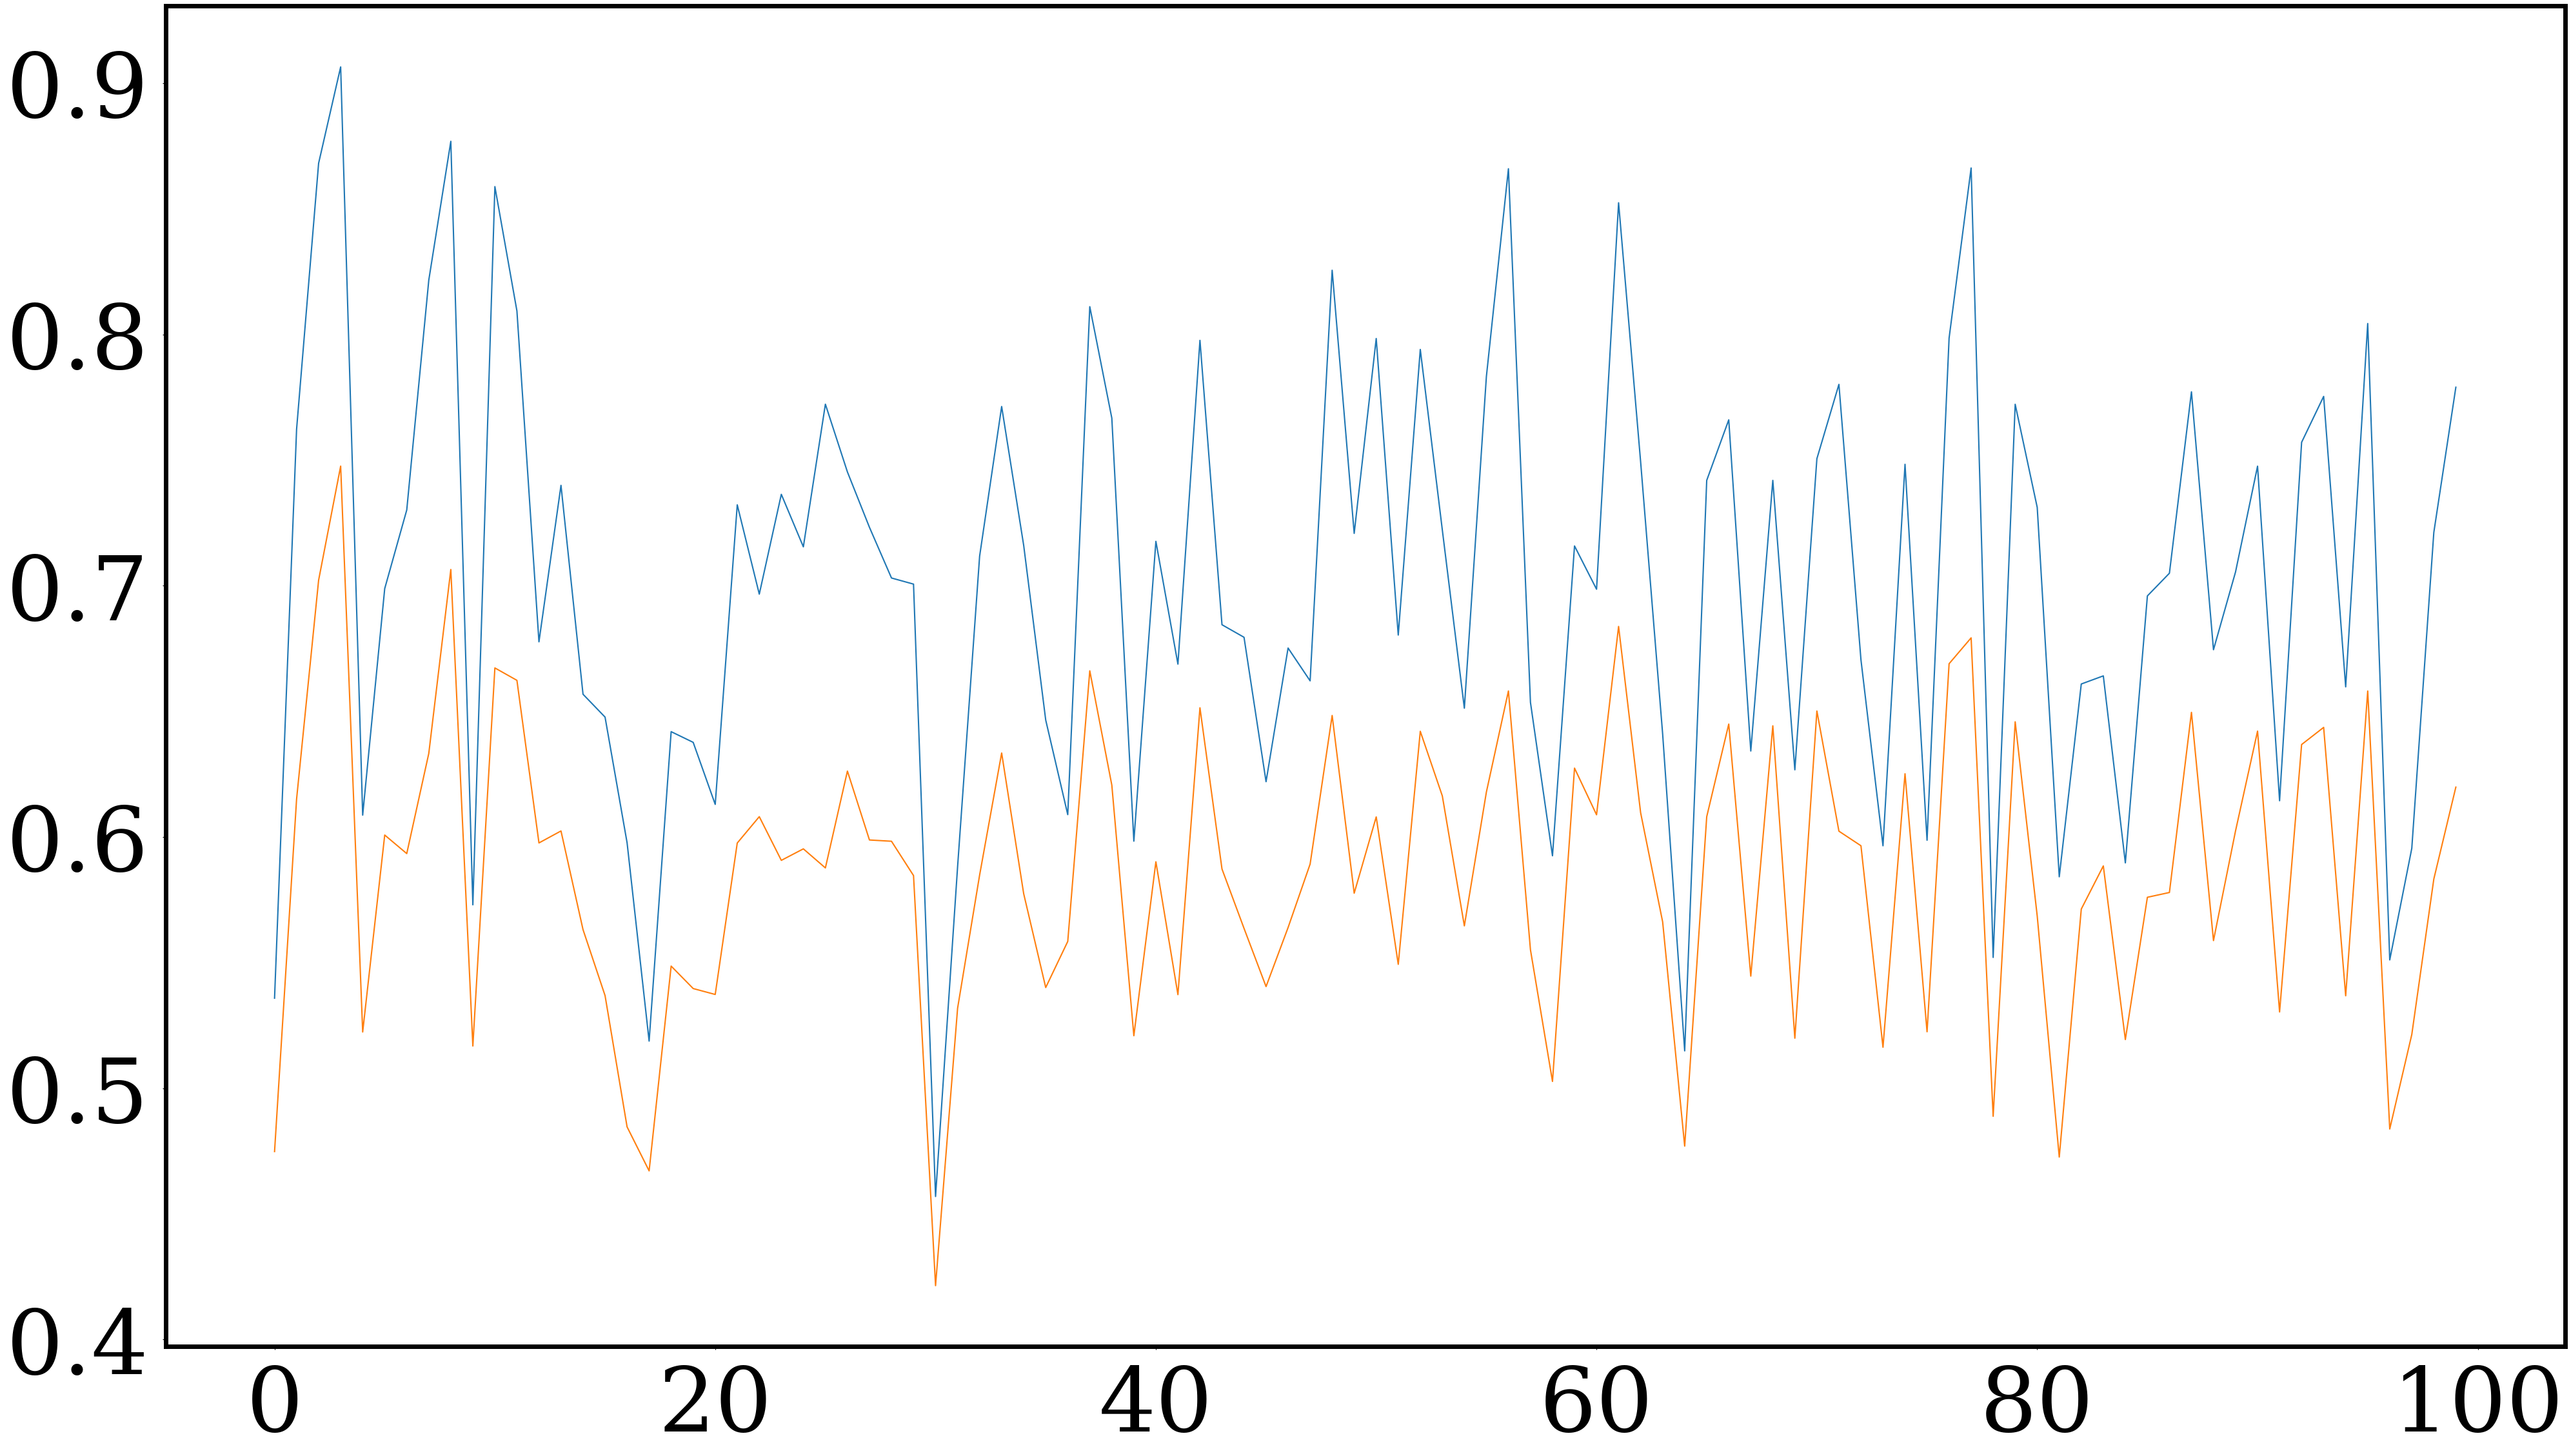

In [9]:
plt.plot(true_opt)
plt.plot(vqa_opt)

In [13]:
np.save("data/true_opt.npy",true_opt)
np.save("data/vqa_opt.npy",vqa_opt)

In [3]:
true_opt = np.load("data/true_opt.npy")
vqa_opt = np.load("data/vqa_opt.npy")
true_opt_7 = np.load("data/true_opt_7.npy")
vqa_opt_7 = np.load("data/vqa_opt_7.npy")

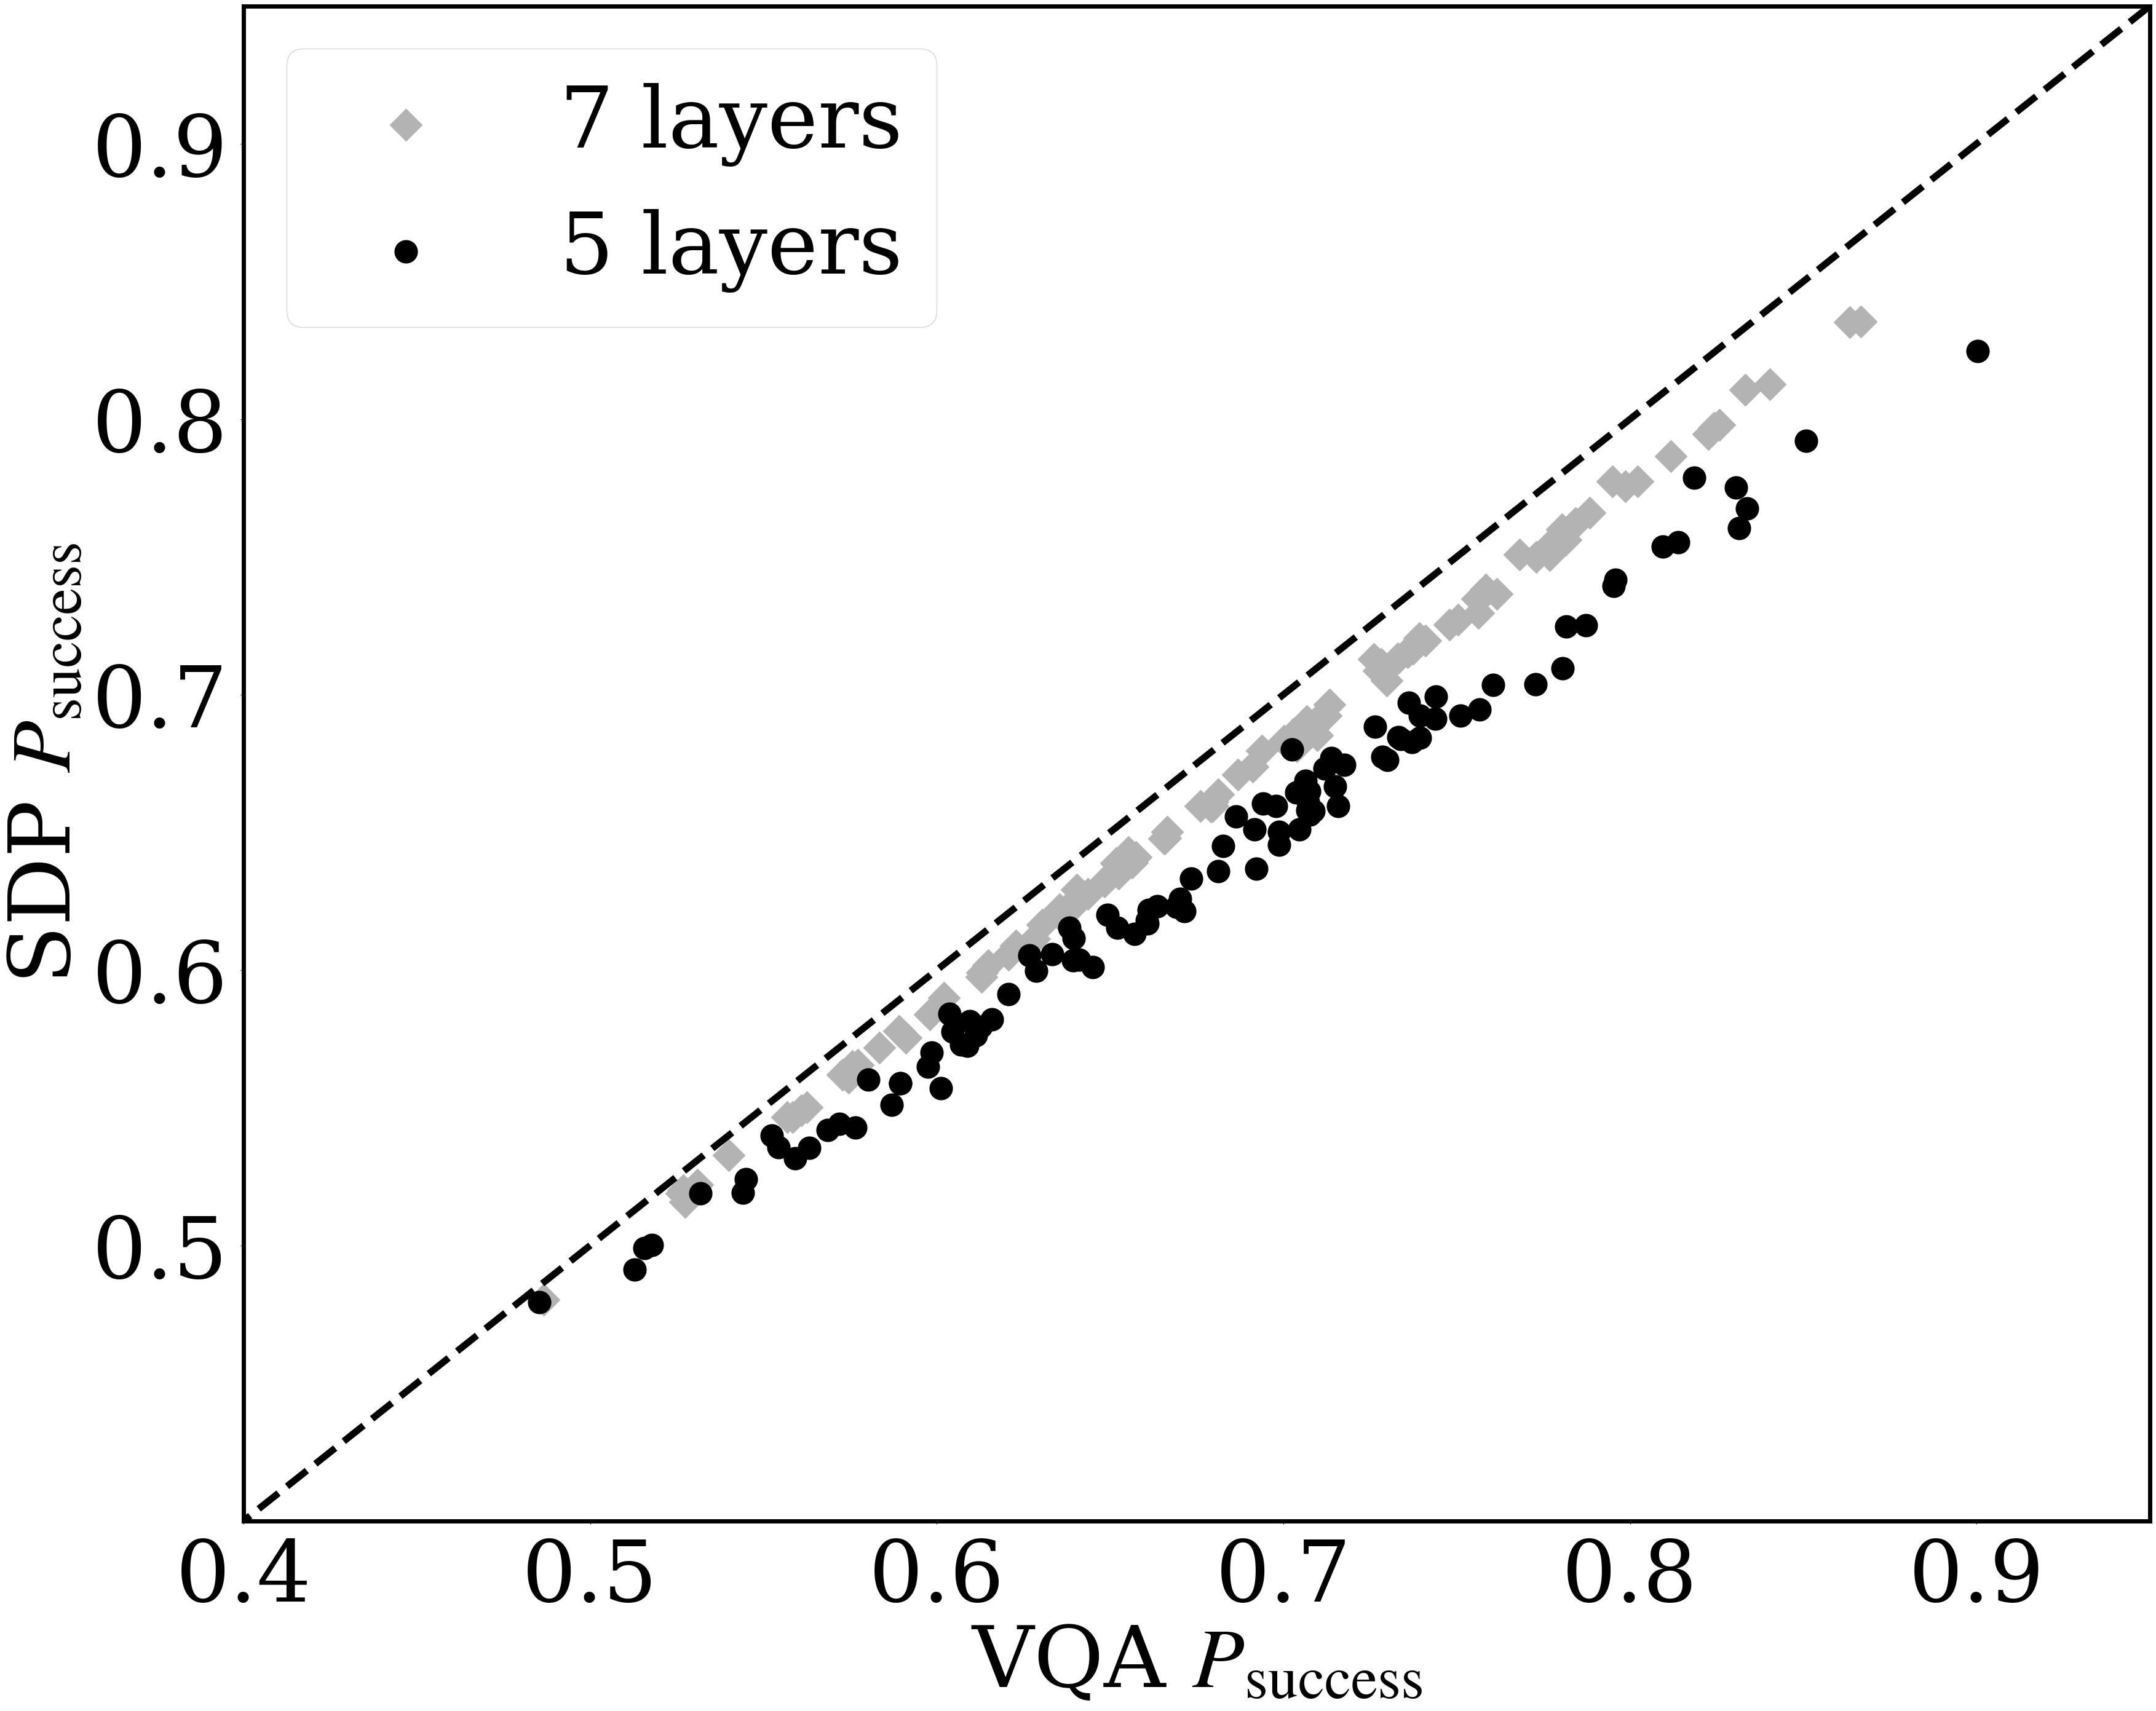

In [8]:

plt.scatter(true_opt_7,vqa_opt_7,color='0.7',s=700,label="7 layers",marker="D")
plt.scatter(true_opt,vqa_opt,color='k',s=700,label="5 layers")
plt.rcParams["figure.figsize"] = (40,32)
plt.plot([0,1],[0,1],'k--',linewidth=8)
plt.xlim(0.4, 0.95)
plt.ylim(0.4,0.95)
plt.yticks([0.5,0.6,0.7,0.8, 0.9])
plt.ylabel("SDP $P_{\mathrm{success}}$")
plt.xlabel("VQA $P_{\mathrm{success}}$")
plt.legend()
plt.show()